# Ensemble-Additive Model: Lower Back Pain Symptom 

[Data Set Source](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)   

## Imports

In [1]:
import numpy as np
import pandas as pd 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook
from sklearn.utils import shuffle
from sklearn import preprocessing

## Loading Data
#### 310 Observations, 13 Attributes (12 Numeric Predictors, 1 Binary Class Attribute - No Demographics)

In [2]:
df = pd.read_csv("/Users/zorazhang/Desktop/backPainSymp.csv")
df = df.drop(df.columns[13], axis=1)
df.columns = ['pelvic incidence', 'pelvic tilt', 'lumbar lordosis angle', 'sacral slope', 'pelvic radius', 'degree spondylolisthesis', 'pelvic slope', 'direct tilt', 'thoracic slope', 'cervical tilt', 'sacrum angle', 'scoliosis slope', 'result']
df['result'] = df['result'].map({'Abnormal': 1, 'Normal': 0})
df = shuffle(df)
df.head()

,pelvic incidence,pelvic tilt,lumbar lordosis angle,sacral slope,pelvic radius,degree spondylolisthesis,pelvic slope,direct tilt,thoracic slope,cervical tilt,sacrum angle,scoliosis slope,result
100,84.585607,30.361685,65.479486,54.223922,108.010219,25.118478,0.341665,30.4108,15.7092,11.58279,-1.273566,29.6399,1
231,53.911054,12.939318,39.000000,40.971736,118.193035,5.074353,0.146745,17.7116,17.7521,16.43174,0.138844,30.7846,0
84,76.326002,42.396204,57.200000,33.929797,124.267007,50.127457,0.583098,33.1635,8.3830,13.75752,-32.106343,18.6868,1
66,78.491730,22.181798,60.000000,56.309932,118.530327,27.383213,0.008486,7.5647,12.6737,8.03422,-22.037558,32.0972,1
175,56.563824,8.961262,52.577846,47.602562,98.777115,50.701873,0.588948,18.1451,13.9634,12.46567,0.744240,32.4471,1


#### Normalization

In [3]:
min_max_scaler = preprocessing.MinMaxScaler()
df = pd.DataFrame(min_max_scaler.fit_transform(df))
df.columns = ['pelvic incidence', 'pelvic tilt', 'lumbar lordosis angle', 'sacral slope', 'pelvic radius', 'degree spondylolisthesis', 'pelvic slope', 'direct tilt', 'thoracic slope', 'cervical tilt', 'sacrum angle', 'scoliosis slope', 'result']

## Net
#### Each net has 2 hidden layers, each layer has 300 nodes, M = 5

In [4]:
class Net(nn.Module):
    def __init__(self, layerWidth=300):
        super(Net, self).__init__();
        self.fc1 = nn.Linear(1, layerWidth)
        nn.init.kaiming_normal_(self.fc1.weight)
        self.fc2 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc2.weight)
        self.fc3 = nn.Linear(layerWidth, layerWidth)
        nn.init.kaiming_normal_(self.fc3.weight)
        self.fc4 = nn.Linear(layerWidth,1)
        nn.init.kaiming_normal_(self.fc4.weight)
    def forward (self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

#### Create a 2D neural networks array: nets

In [5]:
nets = []
for i in range(5):
    subnets = []
    for i in range(len(df.columns)):
        subnets.append( Net() )
    nets.append(subnets)

In [14]:
for net in nets:
    for subnet in net:
        with torch.no_grad():
            subnet.state_dict()['fc4.weight'] /= 10

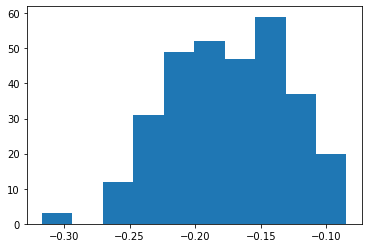

In [15]:
allInput = np.array(df['pelvic incidence'])
tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
tensorAllOut = nets[0][0](tensorAllInput)
allOut = tensorAllOut.detach().numpy()
plt.hist(allOut)
plt.show()

## Minibatch
#### 5 batches, each contains 50 rows

In [16]:
batches = []
for i in range (5):
    batch = df.sample(n = 20,replace = True)
    batches.append(batch)

#### Split each batch into Inputs and Targets

In [17]:
# 5 groups of 12-column inputs
inputs = []
# 5 groups of 1-column target
targets = []
# All the column names
titles = []
for i in range(len(batches)):
    titles = np.array((batches[i].columns))
    inputs.append(batches[i].iloc[:, 0:len(df.columns) - 1])
    targets.append(batches[i]['result'])
print(inputs[1].shape)
titles = titles[:-1]
print(titles)

(20, 12)
['pelvic incidence' 'pelvic tilt' 'lumbar lordosis angle' 'sacral slope'
 'pelvic radius' 'degree spondylolisthesis' 'pelvic slope' 'direct tilt'
 'thoracic slope' 'cervical tilt' 'sacrum angle' 'scoliosis slope']


#### Organize inputs into a torch tensor: In

In [18]:
In = []
for index in range(len(inputs)):
    subIn = []
    for i, feature in enumerate(titles):
        columnInput = torch.from_numpy(np.array(inputs[index][feature])).float().reshape(-1,1)
        subIn.append(columnInput)
    In.append(subIn)

# Usage format: 
# print(In[0][11])
# 0 denotes the batch index, 11 denotes the feature index

#### Organize targets into a torch tensor: Target

In [19]:
Target = []
for index in range (len(targets)):
    columnTarget = torch.from_numpy(np.array(targets[index])).float().reshape(-1,1)
    Target.append(columnTarget)

# Usage format:
# print(Target[0])
# 0 denotes the batch index

## Training

In [20]:
for i, net in enumerate(nets):
    
    netTarget = Target[i]
    netInput = In[i] 
        
    optimizers = [optim.Adam(net[i].parameters()) for i in range(len(net))]
    criterion = nn.MSELoss()
    epochs = tqdm_notebook(range(500))

    for epoch in epochs:

        for optimizer in optimizers:
            optimizer.zero_grad()

        Out = [net[i](netInput[i]) for i in range(len(net) - 1)]
        totalOut = sum(Out)
        totalOut = torch.sigmoid(totalOut)
        loss = criterion(totalOut, netTarget)
        loss.backward()

        for optimizer in optimizers:
            optimizer.step()

        epochs.set_description(str(loss.data.item()))

## Plotting

#### Each net's performance on different symptoms

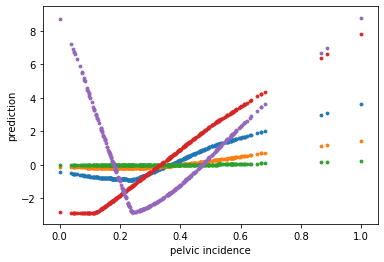

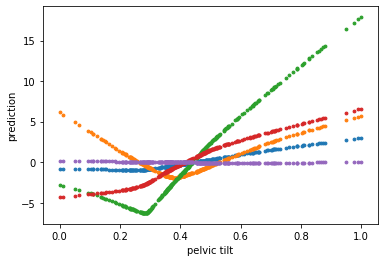

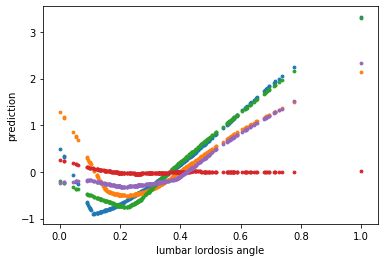

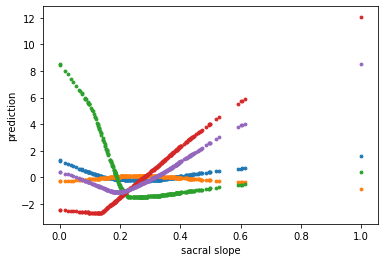

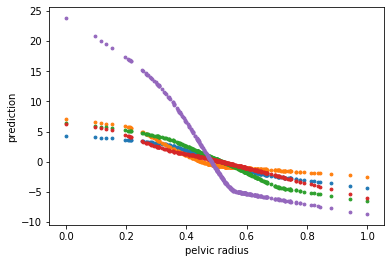

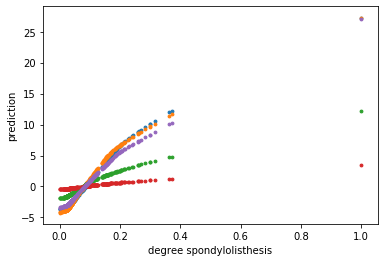

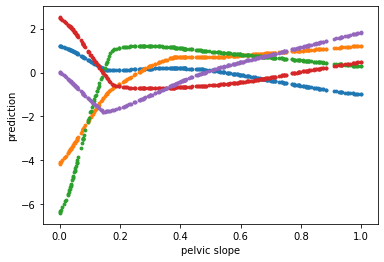

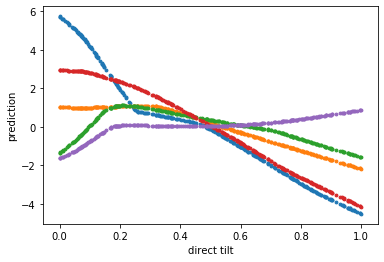

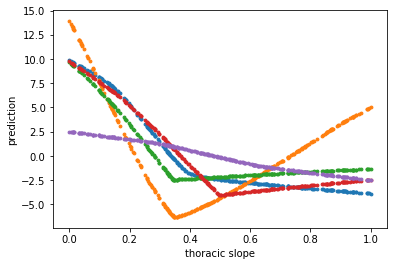

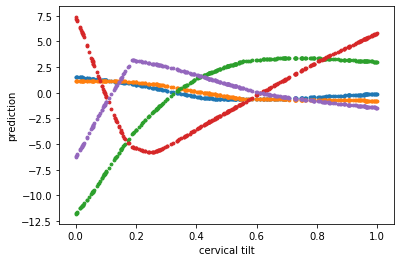

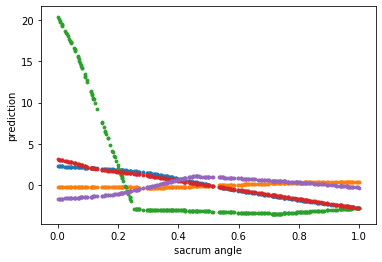

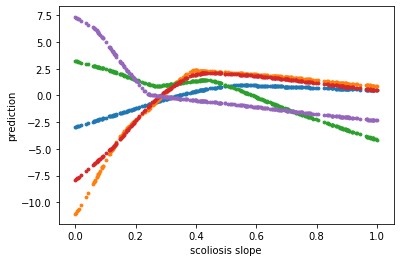

[2.072056695818901, 2.036993023008108, 7.857831562927458, 4.871740033850074, 2.6561558470129967]


In [21]:
offset = [0] * 5
for i, feature in enumerate(titles):
    for n in range (5):
        mynet = nets[n]
        allInput = np.array(df[feature])
        tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
        tensorAllOut = mynet[i](tensorAllInput)
        allOut = tensorAllOut.detach().numpy()
        
        meanOut = np.mean(allOut)
        newOut = allOut - meanOut
        offset[n] = offset[n] + meanOut
        
        plt.scatter(allInput, newOut, s = 8)
        plt.xlabel(feature)
        plt.ylabel('prediction')
    plt.show()
print(offset)

In [ ]:
for i, feature in enumerate(titles):
    meanOut = []
    sds = []
    
    for n in range (5):
        mynet = nets[n]
        allInput = np.array(df[feature])
        tensorAllInput = torch.from_numpy(allInput).float().reshape(-1,1)
        tensorAllOut = mynet[i](tensorAllInput)
        allOut = tensorAllOut.detach().numpy()
        print(allOut.shape)
        
        for k in range(len(allOut)):
            meanOut.append(allOut)
    mean = np.mean(np.array(meanOut))
    sds.append(np.std(meanOut))
    plt.errorbar(allInput, mean, yerr = sds, ecolor = 'lightblue')
    plt.xlabel(feature)
    plt.ylabel('prediction')
    plt.show()